In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import enlighten
from collections import defaultdict as ddict

#!source activate my-rdkit-env && python
from rdkit import RDLogger
from rdkit.Chem import PandasTools, AllChem as Chem, Descriptors
from rdkit.ML.Descriptors.MoleculeDescriptors import MolecularDescriptorCalculator
from rdkit.Chem.rdmolops import SanitizeFlags

# from rdkit import Chem

from IPython.core.display import HTML

#ML requirements sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.svm import SVR
from sklearn.cluster import KMeans


RDLogger.logger().setLevel(RDLogger.CRITICAL)

# RDLogger.logger().setLevel(RDLogger.WARNING)

not_used_desc = ['MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge']
#molecule descriptor calculator
desc_calc = MolecularDescriptorCalculator([x for x in [x[0] for x in Descriptors.descList] if x not in not_used_desc])


In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.test.gpu_device_name()))

Num GPUs Available:  13


2022-07-04 11:09:51.293608: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-04 11:09:51.328244: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 11:09:51.331992: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-04 11:09:51.332098: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

## Defining functions to use

In [3]:
#write some stuff
def stats(A,B):
    assert len(A) == len(B)
    R2 = np.round(r2_score(A, B))
    MAE = np.round(mean_absolute_error(A,B))
    return f'R2: {np.round(R2, 3)}\n' \
            f'MAE: {np.round(MAE, 3)}'

def show(df):
    """Render the molecules within a DataFrame correctly"""
    return HTML(df.to_html(notebook=True))

def remove_aromatisation(mol):
    # for atom in mol.GetAromaticAtoms():
    #     #bugfixing
    #     # print(atom.getIsAromatic())
    #     # print(atom.getSymbol())
    #     atom.SetIsAromatic(False)

    for atom in mol.GetAtoms():
        if (not atom.IsInRing()) and atom.GetIsAromatic():
            atom.SetIsAromatic(False)
    for bond in mol.GetBonds():
        if (not bond.IsInRing()) and bond.GetIsAromatic():
            bond.SetIsAromatic(False)

def get_frag_env(mol, atom_x, radius):
    bond_x = Chem.FindAtomEnvironmentOfRadiusN(mol, radius, atom_x)
    if len(bond_x) == 0:
        return None
    atom_x_set = set()
    for b_x in bond_x:
        b = mol.GetBondWithIdx(b_x)
        atom_x_set.add(b.GetBeginAtomIdx())
        atom_x_set.add(b.GetEndAtomIdx())
    return Chem.MolFromSmiles(Chem.MolFragmentToSmiles(mol, atom_x_set, bond_x), sanitize=False)

def get_frag(mol, atom_x, radius):
    frag = None
    r = radius

    while frag is None and r > 0:
        frag = get_frag_env(mol, atom_x, r)
        r -= 1
    if frag is None:
        raise ValueError("No fragment extracted")

    # error/issue catching#or
    r = radius + 1
    #sanitised to calculated descriptors
    not_sanitised = Chem.SanitizeMol(frag, catchErrors=True)
    count = 0
    tot_atoms = frag.GetNumAtoms()
    while not_sanitised:
        if count > tot_atoms:
            raise ValueError("Unable to sanitise molecules")
        # probs = Chem.DetectChemistryProblems(frag)
        # for p in probs:
        #     print("Issue is: " + p.GetType())
        if not_sanitised == SanitizeFlags.SANITIZE_KEKULIZE:
            # if count == 5:
            #     raise ValueError("Unable to sanitise molecules")
            remove_aromatisation(frag)
        elif not_sanitised == SanitizeFlags.SANITIZE_PROPERTIES:
            frag = get_frag_env(mol, atom_x, r)
            r += 1
        not_sanitised = Chem.SanitizeMol(frag, catchErrors=True)
        count += 1
    # print(Chem.MolToSmiles(frag))
    return frag

# def fix_nitrogen(mol):
#     mol.UpdatePropertyCache(strict=False)
#     ps = Chem.DetectChemistryProblems(mol)
#     if ps:
#         for p in ps:
#             if p.GetType() == 'AtomValenceException':
#                 at = mol.GetAtomWithIdx(p.GetAtomIdx())
#             if at.GetAtomicNum()==7 and at.GetFormalCharge()==0 and at.GetExplicitValence()==4:
#                 at.SetFormalCharge(1)
#     if not ps:
#         print("Chemically fine")
    # return mol


In [4]:
#assay identification number
#AID as written in PubChem database

#hERG ion channel modulator assay
assay = 1511

In [5]:
#backup excel method
excelfile = "AID_1511_datatable_all.csv"

In [6]:
ERROR_FLAG = False

In [7]:
#compile Assay molecules into SDF
from pubapi import get_data_AID_csv as assayinfo

#get assay info

try:
    assay_info = assayinfo.get_data_AID_csv(assay)

except:
    print("Error in download")
    ERROR_FLAG = True



# assay_info = assayinfo.get_data_AID_csv(assay)

# with open(excelfile, 'r') as csvfile:
#     reader = csv.reader(csvfile, delimiter=',')
#     assay_info = []
#     headers = ['PUBCHEM_ASSAY_ID']
#     for id, row in enumerate(reader):
#         if id == 0:
#             headers.append(row[1:4])
#             assay_info.append(headers)
#         try: 
#             int(row[0]) == 1
#         except ValueError:
#             #line is descriptive
#             continue
#         if row[2] == '':
#             #CID is missing/not present
#             row[2] = 0
#             #continue

#         line = [assay, int(row[1]), int(row[2]), row[3]]
#         assay_info.append(line)



Number of substances tested in assay AID 1511 are: 305679
Assay size is over 10,000
This exceeds the max number of lines that can be requested at once.
Requesting info of assay 1511


Done.
Assay 1511 has been successfully downloaded.


In [8]:
all_df = pd.DataFrame(assay_info[1:],columns=assay_info[0])

# all_df = pd.DataFrame(assay_info[1:],columns=assay_info[0])
#get list of CIDs from the assay
print(all_df.head(10))

CIDs = all_df['PUBCHEM_CID'].to_list()

# from pubapi import get_SDF_CIDs as SDFs

# SDFs.compile_SDFs(CIDs)


   PUBCHEM_ASSAY_ID  PUBCHEM_SID  PUBCHEM_CID PUBCHEM_ACTIVITY_OUTCOME  \
0              1511     56314828         1988                 Inactive   
1              1511     56321651       425322                 Inactive   
2              1511     56322145     24981957                 Inactive   
3              1511     51090143      7384392                 Inactive   
4              1511     51090795      7423030                 Inactive   
5              1511     51090141      7526417                 Inactive   
6              1511     51090145     16268999                 Inactive   
7              1511     51090492     18573514                 Inactive   
8              1511     51090139     18577942                 Inactive   
9              1511     51089977     18582778                 Inactive   

   PUBCHEM_ACTIVITY_SCORE  
0                       0  
1                       0  
2                       0  
3                       0  
4                       0  
5                

In [9]:
all_df["PUBCHEM_CANONICAL_SMILES"] = np.nan

In [10]:
#add the SMILES from the SQL database to each of the CIDs in the 

#do it with internal mariadb
#uncomment
#↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓

from search_laurus import query_db

query = f'SELECT * FROM aggregator.pubchem_compound WHERE ' 

pbar = enlighten.Counter(total=(len(CIDs)), desc='Querying Laurus...', unit='ticks')

if not ERROR_FLAG:
    try:
        for ID, i in enumerate(CIDs):
            # if ID == 25000:
            #     break
            #Search for CIDs
            CID_search = query + f'pubchem_id = {i};' 
            info = query_db(CID_search)

            #parse
            for j in info:
                # pubchem = j[0]
                # compound = j[1]
                smiles = j[5]
                all_df.loc[all_df["PUBCHEM_CID"] == i, 'PUBCHEM_CANONICAL_SMILES'] = smiles

            pbar.update()
    except:
        print("Error in connecting to Laurus database")
        ERROR_FLAG = True
    


CC(=O)OC1=CC=CC=C1C(=O)O


Error connecting to laurus: Can't connect to server on 'laurus.fmp-berlin.de' (99)
Error in connecting to Laurus database


In [11]:
#backup method to load dataframe
if not ERROR_FLAG:
    all_df.to_csv('backup_df.csv')

In [ ]:
#load df upon laurus/pubchem failure
if ERROR_FLAG:
    all_df = pd.read_csv('backup_df.csv')
    ERROR_FLAG = False

In [13]:
#now convert the SMILES strings to MOL objects
if not ERROR_FLAG:
    PandasTools.AddMoleculeColumnToFrame(all_df, 'PUBCHEM_CANONICAL_SMILES', 'ROMol', includeFingerprints=True)


In [14]:
#write molecules to SDF
if not ERROR_FLAG:
    PandasTools.WriteSDF(all_df, f'{assay}_compounds.sdf', molColName='ROMol', properties=all_df.columns)

In [15]:
#load SDF file

if ERROR_FLAG:
    print("Error in downloading data, using backup data (if available)")
    import os

    sdf_path = os.path.join(os.getcwd(), f'{assay}_compounds.sdf')
    backup_df = PandasTools.LoadSDF(sdf_path)
    training_data = backup_df.copy()
    
else:
    training_data = all_df.copy()
    


Error in downloading data, using backup data (if available)


,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,ID,ROMol
0,1511,56314828,1988,Inactive,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,,
1,1511,56321651,425322,Inactive,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,,
2,1511,56322145,24981957,Inactive,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,,
3,1511,51090143,7384392,Inactive,CCS(=O)(=O)N1CCC2(CC1)N(CCO2)S(=O)(=O)C3=CC=C(...,,

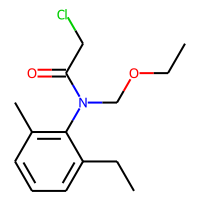
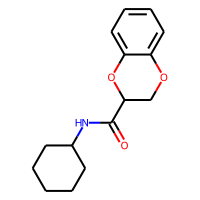
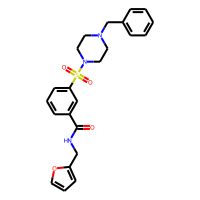
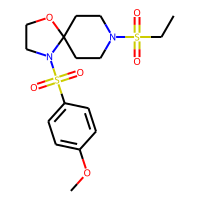

In [17]:
show(training_data.head(4))

In [18]:
#TODO
#get fingerprints and split into fragments.
min_radius = 3
max_radius = 5

radii = list(range(min_radius, max_radius))

In [ ]:
# frags = ddict(list)

# #check to see how long this may actually take
# frag_prog = enlighten.Counter(total=(len(test_df)), desc='Creating Fragments...', unit='ticks')

# # show(test_df.drop(129607, axis=0))

# for index, row in test_df.iterrows():
#     atom_x = 0
#     mol = row.MOL
#     check_frags = []
#     for i in radii:
#         try:
#             # frags[i].append(get_frag(mol, atom_x, i))
#             frag = get_frag(mol, atom_x, i)
#             check_frags.append((i, frag))
#         except:
#             print(index)
#             # test_df.drop(index, axis=0, inplace=True)

#     if len(check_frags) != len(radii):
#         test_df.drop(index, axis=0, inplace=True)
#     else:
#         for i in check_frags:
#             frags[i[0]].append(i[1])
#     frag_prog.update()

# for i in radii:
#     test_df[f'FRAG_R{i}'] = frags[i]

# show(test_df.head(4))


In [19]:
frags = ddict(list)

#check to see how long this may actually take
frag_prog = enlighten.Counter(total=(len(training_data)), desc='Creating Fragments...', unit='ticks')

for index, row in training_data.iterrows():
    atom_x = 0
    mol = row.ROMol
    check_frags = []
    for i in radii:
        try:
            # frags[i].append(get_frag(mol, atom_x, i))
            frag = get_frag(mol, atom_x, i)
            check_frags.append((i, frag))
        except:
            print(f'Removing line: {index}')
    if len(check_frags) != len(radii):
        training_data.drop(index, axis=0, inplace=True)
    else:
        for i in check_frags:
            frags[i[0]].append(i[1])
            
    frag_prog.update()


for i in radii:
    training_data[f'FRAG_R{i}'] = frags[i]

# show(training_data.head(4))




Removing line: 77430
Removing line: 81689
Removing line: 83743
Removing line: 84663
Removing line: 106970
Removing line: 111820
Removing line: 125560
Removing line: 129607
Removing line: 132093
Removing line: 132093
Removing line: 135417
Removing line: 135417
Removing line: 139592
Removing line: 153332
Removing line: 173613
Removing line: 174838
Removing line: 181072
Removing line: 181558
Removing line: 193700
Removing line: 193700
Removing line: 215789
Removing line: 229814
Removing line: 231445
Removing line: 241868
Removing line: 290377
Removing line: 291099
Removing line: 302647
Removing line: 302647


,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,ID,ROMol,FRAG_R3,FRAG_R4
0,1511,56314828,1988,Inactive,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,,,,
1,1511,56321651,425322,Inactive,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,,,,
2,1511,56322145,24981957,Inactive,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,,,,
3,1511,51090143,7384392,Inactive,CCS(=O)(=O)N1CCC2(CC1)N(CCO2)S(=O)(=O)C3=CC=C(...,,,,

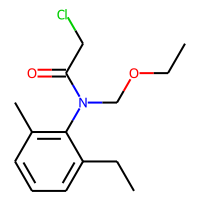
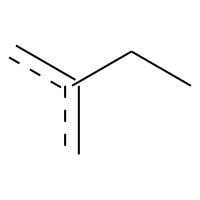
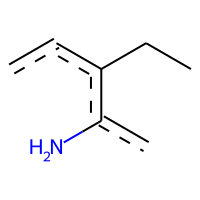
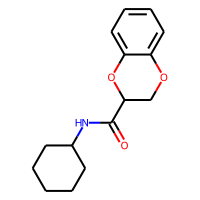
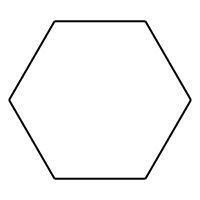
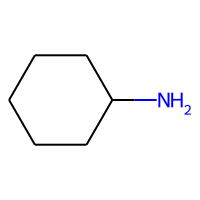
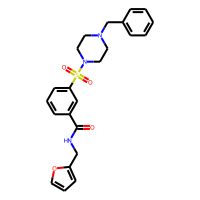
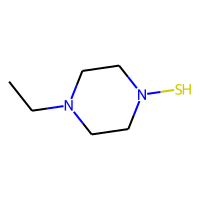
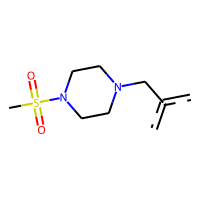
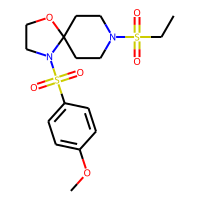
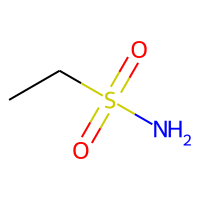
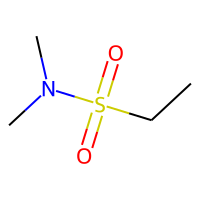

In [23]:
show(training_data.head(4))

In [ ]:
# keys = radii + [max_radius]
# descs_check = ddict(list)

# limit = 2

# for index, row in training_data.iterrows():
#     if index > limit:
#         break
#     for i in keys:
#         mol = row.MOL if i == max_radius else row[f'FRAG_R{i}']
#         descs_check[i].append(desc_calc.CalcDescriptors(mol))

# print(len(descs_check[4]))

3


In [22]:
#Calculate descriptors for fragments

keys = radii + [max_radius]

#this guy used a dictionary like a list...
descr = ddict(list)

morgan0 = ddict(list)
morgan1 = ddict(list)
morgan2 = ddict(list)
morgan3 = ddict(list)
topol = ddict(list)
atpair = ddict(list)


descriptor_pb = enlighten.Counter(total=(len(training_data)), desc='Calculating descriptors...', unit='ticks')

# limit = 2

for index, row in training_data.iterrows():
    nan_flag = False

    #list indexing > dictionaries
    descriptors_check = []
    ecpf_check = []
    # if index > limit:
    #     break
    for i in keys:
        # print(i)
        mol = row.ROMol if i == max_radius else row[f'FRAG_R{i}']   
        descriptor = desc_calc.CalcDescriptors(mol)
        for j in descriptor:
            if np.isnan(j):
                nan_flag = True
                break 
        if nan_flag:
            print(index)
            break
        descriptors_check.append(descriptor)

        #ECPF    
        morgan_0vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=0)
        morgan_1vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=1)
        morgan_2vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=2)
        morgan_3vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=3)

        topol_vec =  Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol)

        atpair_vec = Chem.GetHashedAtomPairFingerprintAsBitVect(mol)

        check_vecs = [morgan_0vec, morgan_1vec, morgan_2vec, morgan_3vec, topol_vec, atpair_vec]
        for k in check_vecs:
            array = np.array(i)
            nan_flan = np.isnan(array).any()
        if nan_flag:
            break

        ecpf_check.append(check_vecs)

        # descr[i].append(descriptor)
        #issue is it may append before molecules are checked
        
        
    if nan_flag:
        print(f'Line {index} contains NaN values, removing...')
        training_data.drop(index, inplace=True)
    else:
        for ID, l in enumerate(keys):
            descr[l].append(descriptors_check[ID])

        for m in ecpf_check:
            for ID, n in enumerate(keys):
                morgan0[n].append(k[ID])
                morgan1[n].append(k[ID])
                morgan2[n].append(k[ID])
                morgan3[n].append(k[ID])
                topol[n].append(k[ID])
                atpair[n].append(k[ID])
        

    #testing the length of the frag dict
    descriptor_pb.update()

188295
Line 188295 contains NaN values, removing...
193371
Line 193371 contains NaN values, removing...
197613
Line 197613 contains NaN values, removing...
200341
Line 200341 contains NaN values, removing...
206757
Line 206757 contains NaN values, removing...
209939
Line 209939 contains NaN values, removing...
213543
Line 213543 contains NaN values, removing...
213805
Line 213805 contains NaN values, removing...
213807
Line 213807 contains NaN values, removing...
214954
Line 214954 contains NaN values, removing...
218978
Line 218978 contains NaN values, removing...
220209
Line 220209 contains NaN values, removing...
220330
Line 220330 contains NaN values, removing...
220551
Line 220551 contains NaN values, removing...
220961
Line 220961 contains NaN values, removing...
221339
Line 221339 contains NaN values, removing...
222438
Line 222438 contains NaN values, removing...
223416
Line 223416 contains NaN values, removing...
227519
Line 227519 contains NaN values, removing...
228518
Line 

In [74]:
# #create fingerprints for all molecules/fragments

# morgan0 = ddict(list)
# morgan1 = ddict(list)
# morgan2 = ddict(list)
# morgan3 = ddict(list)
# topol = ddict(list)
# atpair = ddict(list)

# fingerprint_pb = enlighten.Counter(total=(len(training_data)), desc='Calculating fingerprints...', unit='ticks')

# for index, row in training_data.iterrows():
#     nan_flag = False
#     descriptors_check = []
#     for i in keys:
#         mol = row.ROMol if i == max_radius else row[f'FRAG_R{i}']

#         morgan_0vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=0)
#         morgan_1vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=1)
#         morgan_2vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=2)
#         morgan_3vec = Chem.GetMorganFingerprintAsBitVect(mol, radius=3)

#         topol_vec =  Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol)

#         atpair_vec = Chem.GetHashedAtomPairFingerprintAsBitVect(mol)

#         check_vecs = [morgan_0vec, morgan_1vec, morgan_2vec, morgan_3vec, topol_vec, atpair_vec]
#         for j in check_vecs:
#             array = np.array(i)
#             nan_flan = np.isnan(array).any()
#         if nan_flag:
#             break

#         descriptors_check.append(check_vecs)

#         # morgan0[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=0))
#         # morgan1[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=1))
#         # morgan2[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=2))
#         # morgan3[i].append(Chem.GetMorganFingerprintAsBitVect(mol, radius=3))
#         # topol[i].append(Chem.GetHashedTopologicalTorsionFingerprintAsBitVect(mol))
#         # atpair[i].append(Chem.GetHashedAtomPairFingerprintAsBitVect(mol))
    
#     if nan_flag:
#         print(f'Line {index} contains NaN values, removing...')
#         training_data.drop(index, inplace=True)
#     else:
#         for k in descriptors_check:
#             for ID, l in enumerate(keys):
#                 morgan0[l].append(k[ID])
#                 morgan1[l].append(k[ID])
#                 morgan2[l].append(k[ID])
#                 morgan3[l].append(k[ID])
#                 topol[l].append(k[ID])
#                 atpair[l].append(k[ID])


#     fingerprint_pb.update()


In [1]:
# #replace activity with 1 if active and 0 if inactive
# training_data["PUBCHEM_ACTIVITY_OUTCOME"].replace("Inactive", 0, inplace=True)
# training_data["PUBCHEM_ACTIVITY_OUTCOME"].replace("Active", 1, inplace=True)

# show(training_data.head(4))

NameError: name 'training_data' is not defined

,PUBCHEM_ASSAY_ID,PUBCHEM_SID,PUBCHEM_CID,PUBCHEM_ACTIVITY_OUTCOME,PUBCHEM_CANONICAL_SMILES,MOL,FRAG_R3,FRAG_R4
0,1511,56314828,1988,Inactive,CCC1=CC=CC(=C1N(COCC)C(=O)CCl)C,,,
1,1511,56321651,425322,Inactive,C1CCC(CC1)NC(=O)C2COC3=CC=CC=C3O2,,,
2,1511,56322145,24981957,Inactive,C1CN(CCN1CC2=CC=CC=C2)S(=O)(=O)C3=CC=CC(=C3)C(...,,,
3,1511,51090143,7384392,Inactive,CCS(=O)(=O)N1CCC2(CC1)N(CCO2)S(=O)(=O)C3=CC=C(...,,,

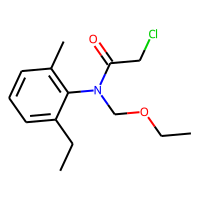
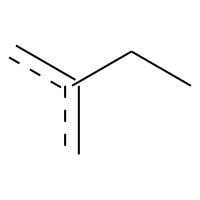
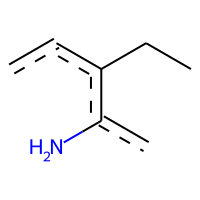
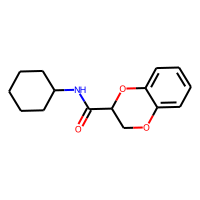
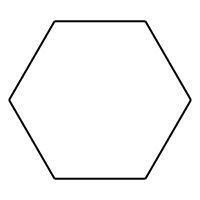
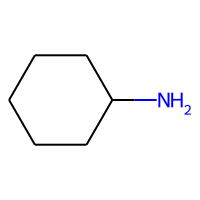
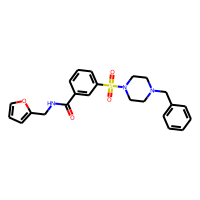
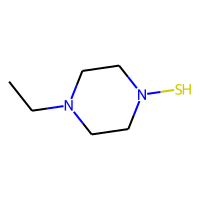
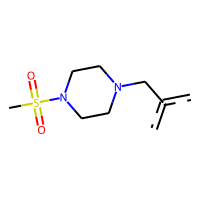
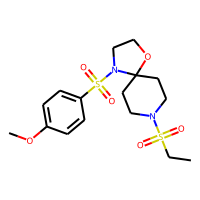
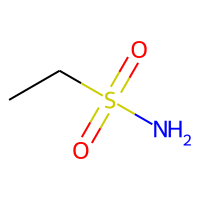
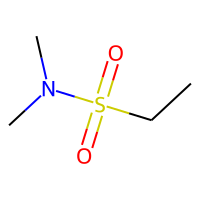

In [107]:
# training_data["PUBCHEM_ACTIVITY_OUTCOME"].replace(0, "Inactive", inplace=True)
# training_data["PUBCHEM_ACTIVITY_OUTCOME"].replace(1, "Active", inplace=True)

# show(training_data.head(4))


y_dataset_test = training_data["PUBCHEM_ACTIVITY_OUTCOME"]
encode = LabelEncoder()
encode.fit(y_dataset_test)
encoded_y = encode.transform(y_dataset_test)

# # print(encoded_y)
# show(training_data.head(4))

In [108]:
training_data.nunique()

PUBCHEM_ASSAY_ID                 1
PUBCHEM_SID                 305427
PUBCHEM_CID                 305360
PUBCHEM_ACTIVITY_OUTCOME         2
PUBCHEM_CANONICAL_SMILES    303867
MOL                         305427
FRAG_R3                     305427
FRAG_R4                     305427
dtype: int64

In [118]:
seed = 20

folds = 5
jobs = 12

# y_data = training_data["PUBCHEM_ACTIVITY_OUTCOME"]

y_data = encoded_y
x_data = dict(Descriptors=descr, Morgan0=morgan0, Morgan1=morgan1, Morgan2=morgan2, 
                  Morgan3=morgan3, Topological=topol, AtomPair=atpair)

kf = KFold(n_splits=folds, shuffle=True, random_state=seed)
spl = list(kf.split(descr[max_radius], y_data))

In [119]:
trees = 5000

In [120]:
#maybe skip this step

#cross validation of the possible descriptors

all_scores = {}
for dsetname, dset in x_data.items():
    # print(dset)
    print(f'Random Forest - {dsetname}:')
    scores = {}
    for i in dset:
        # print(i)
        # print(dset[i])
        est = RandomForestClassifier(n_estimators=trees, random_state=seed, n_jobs=jobs)
        score = cross_val_score(est, dset[i], y_data, cv=spl, error_score='raise')
        print(score)
        scores[i] = dict(r2=np.mean(score), r2_std=np.std(score))
        print(f'\tRadius {i if i != max_radius else "M"} - R²: '
              f'{np.round(scores[i]["r2"], 3)} ± {np.round(scores[i]["r2_std"], 3)}')
    all_scores[dsetname] = scores

Random Forest - Descriptors:
[0.99454867 0.99503978 0.99515429 0.99459769 0.99517066]
	Radius 3 - R²: 0.995 ± 0.0
[0.99449956 0.99489245 0.99515429 0.99461406 0.99507244]
	Radius 4 - R²: 0.995 ± 0.0


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [111]:
#create train/test split
# jobs = 12
radius = 4
test_partition = 0.2
#TODO: NaNs NEED TO BE REMOVED, FIND A METHOD TO DO THIS
# print(len(descr[radius]))
# print(len(y_data))

assert len(descr[radius]) == len(y_data)

x_train, x_test, y_train, y_test = train_test_split(descr[radius], y_data, test_size=test_partition, random_state=seed)


In [112]:
#Final check for NaNs
err =np.argwhere(np.isnan(x_train))
print(err)

[]


In [113]:
#Fire away
rf = RandomForestClassifier(n_estimators=trees, random_state=seed, n_jobs=jobs)
rf.fit(x_train, y_train)

RandomForestClassifier(n_estimators=5000, n_jobs=12, random_state=20)

In [114]:
rf_pred = rf.predict(x_test)
print(stats(y_test, rf_pred))

R2: -0.0
MAE: 0.0


In [115]:
#Feature importance
feat_import = pd.DataFrame(zip(desc_calc.descriptorNames, rf.feature_importances_),
                            columns=['Descriptor', 'Importance']).sort_values('Importance', ascending=False)

In [116]:
feat_import.head(20)

,Descriptor,Importance
20,BCUT2D_MRLOW,0.017859
19,BCUT2D_MRHI,0.016525
17,BCUT2D_LOGPHI,0.016021
4,qed,0.015648
18,BCUT2D_LOGPLOW,0.015199
93,VSA_EState4,0.015114
92,VSA_EState3,0.014713
21,BalabanJ,0.014623
15,BCUT2D_CHGHI,0.014541
14,BCUT2D_MWLOW,0.014435


In [ ]:
svr_scaler = StandardScaler()
svr_scaler